<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is provided as a starting point to help you generate random instances G1 and G2 as mentioned in the handout.

You are free to use and modify it at your own convenience.

---



In [19]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
class DatasetGenerator(object):
    def __init__(self, N=100):
        self.N = N
        self.x = None
        self.v = None
        self.refresh()

    def refresh(self):
        raise Exception("undefined")

In [21]:
class G1(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = st.uniform().rvs((self.N,))

In [22]:
class G2(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

### Uniform distribution ($\mathcal U([0,1])$)

In [23]:
g1 = G1(1000)

Examples:

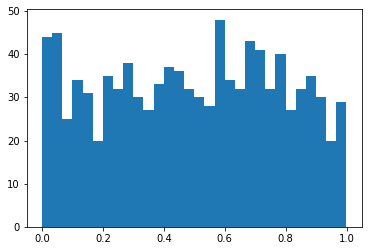

numpy.ndarray

In [24]:
# Plot a histogram of the v array
plt.hist(g1.v, bins=30)
plt.show()
type(g1.v)

/home/spaghet/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


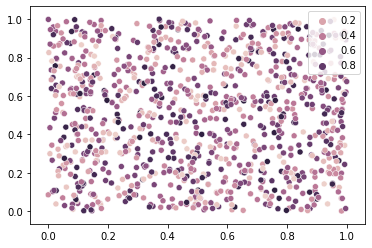

In [25]:
# plot the position of the points
# plt.figure(figsize=(5,5))
sns.scatterplot(g1.x[:,0], g1.x[:,1], hue=g1.v)
plt.show()

You can refresh the dataset

In [26]:
g1.refresh() # generate a new dataset

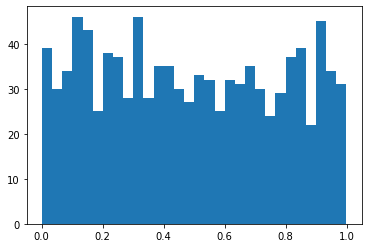

In [27]:
plt.hist(g1.v, bins=30)
plt.show()

Or for instance, you can generate 10 instances and compute the average position of all the points:

In [28]:
m = np.array([0., 0.])

for _ in range(10):
  g1.refresh() # refresh the dataset
  m  += 0.1*g1.x.mean()

print(m)

[0.50420248 0.50420248]


### Test on log-normal distribution

In [29]:
g2 = G2()

Example:

you can use g2 to generate an instance of the lognormal distribution

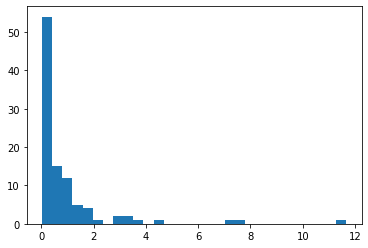

In [30]:
plt.hist(g2.v, bins=30)
plt.show()

/home/spaghet/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


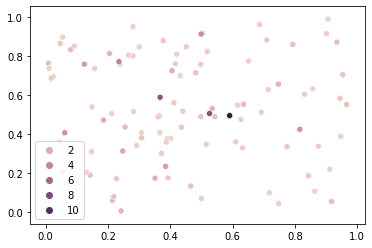

In [31]:
# plot the position of the points
# plt.figure(figsize=(5,5))
sns.scatterplot(g2.x[:,0], g2.x[:,1], hue=g2.v)
plt.show()

In [32]:
g2.refresh() # to generate a new x and v

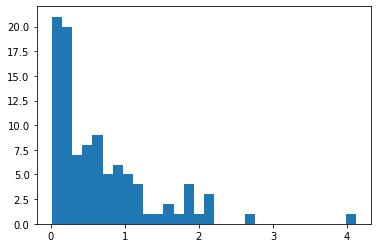

In [33]:
plt.hist(g2.v, bins=30)
plt.show()

---

### Metropolis Hastings

In [34]:
# fill-in this section with your code

from SimulatedAnnealingbis import SimulatedAnnealing
import SimulatedAnnealing as sim_an

In [35]:
print(g1.x.shape)

(1000, 2)


/home/spaghet/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
100%|██████████| 1000/1000 [00:09<00:00, 107.90it/s]
/home/spaghet/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


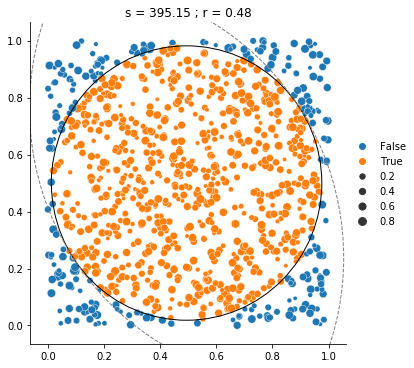

0.006261708531688348
395.1470215942235
74.92663754365608


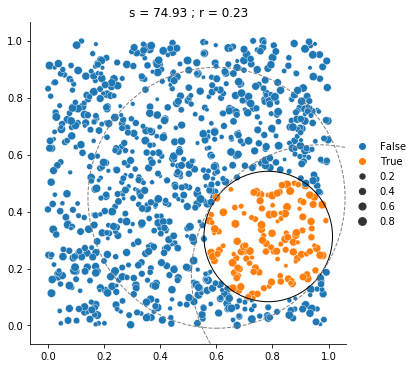

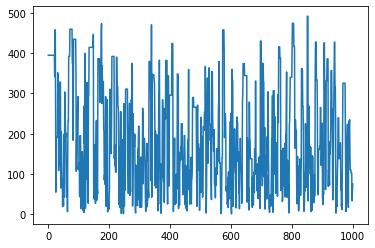

In [38]:
iterations = 1000
SA = SimulatedAnnealing(0, g1,0.2)
print(SA.S.get_objective())
SA.cool_down(iterations)
print(SA.S.get_objective())
plt.plot(range(iterations+1), SA.objectives)
plt.show()

In [ ]:
SA = sim_an.SimulatedAnnealing(0, g1,0.2)
print(SA.S.get_objective())
SA.cool_down(1000)
print(SA.S.get_objective())
plt.plot(range(1001), SA.objectives)
plt.show()
